In [23]:
import pandas as pd
import numpy as np
import yake
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to c:\Users\Jhonr\anaconda3\
[nltk_data]     envs\ods_similarity\lib\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:

# --- Cargar datos ---
df = pd.read_excel("C:/Users/Jhonr/Project_ODS_BERT/Muestra_Estratificada_6_7_9_13_OTROS-Coseno.xlsx")
df.columns = df.columns.str.strip()
df = df.dropna(subset=['Abstract', 'ODS_Original'])

# --- Filtrar ODS válidos ---
ods_validos = ["ODS 6", "ODS 7", "ODS 13"]
df = df[df["ODS_Original"].isin(ods_validos)].reset_index(drop=True)


In [43]:
# --- Stopwords personalizadas ---
custom_stopwords = set(stopwords.words('english')).union({
   'colombia', 'university', 'universidad', 'national', 'based',
    'method', 'study', 'author', 'context', 'case', 'model', 'document', 'system',
    'present', 'use', 'show', 'important', 'observed', 'obtained', 'significant',
    'two', 'also', 'among', 'one', 'may', 'new', 'results', 'authors', 'data','black',
    'hole', 'deformation', 'geometric', 'liquid', 'scenario','friendly', 'designer', 'share',
    'research', 'development', 'process','paper', 'world', 'models', 'description', 
    'Einstein', 'boundary', 'biotechnological', 'oxidant', 'particles', 'regions'

})

# --- YAKE ---
kw_extractor = yake.KeywordExtractor(lan="en", n=2, top=15)
def extract_keywords(text):
    try:
        keywords = kw_extractor.extract_keywords(text)
        return [kw for kw, score in keywords if score < 0.5 and all(w not in custom_stopwords for w in kw.lower().split())]
    except:
        return []

df["keywords"] = df["Abstract"].apply(extract_keywords)

# --- Top keywords por ODS ---
ods_keywords = {}
for ods in df["ODS_Original"].unique():
    all_keywords = df[df["ODS_Original"] == ods]["keywords"].explode()
    keyword_counts = all_keywords.value_counts()
    ods_keywords[ods] = keyword_counts.head(30).index.tolist()


In [45]:
# --- Vector de coocurrencia ---
def cooccurrence_vector(res_keywords, ods_keywords_dict):
    return [
        sum(1 for word in res_keywords if word in ods_keywords_dict["ODS 6"]),
        sum(1 for word in res_keywords if word in ods_keywords_dict["ODS 7"]),
        sum(1 for word in res_keywords if word in ods_keywords_dict["ODS 13"])
    ]

cooc_matrix = df["keywords"].apply(lambda kw_list: cooccurrence_vector(kw_list, ods_keywords))
X = np.vstack(cooc_matrix.values)
le = LabelEncoder()
y = le.fit_transform(df["ODS_Original"])

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# --- GridSearch SVM ---
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.1, 0.01],
    'kernel': ['rbf']
}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

In [46]:
# --- Resultados ---
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("\nReporte de clasificación:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Mejores hiperparámetros encontrados: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Reporte de clasificación:

              precision    recall  f1-score   support

      ODS 13       0.83      0.83      0.83         6
       ODS 6       0.88      1.00      0.93         7
       ODS 7       1.00      0.86      0.92         7

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.91      0.90      0.90        20



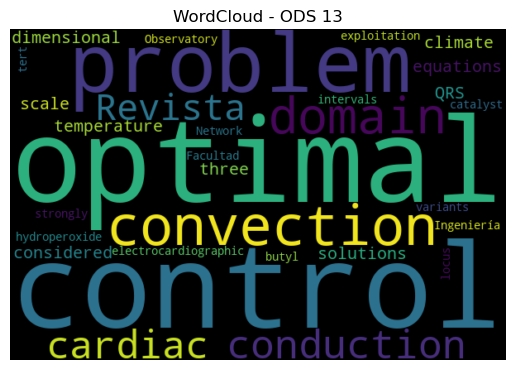

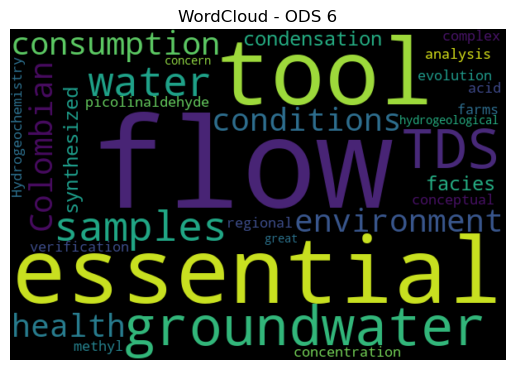

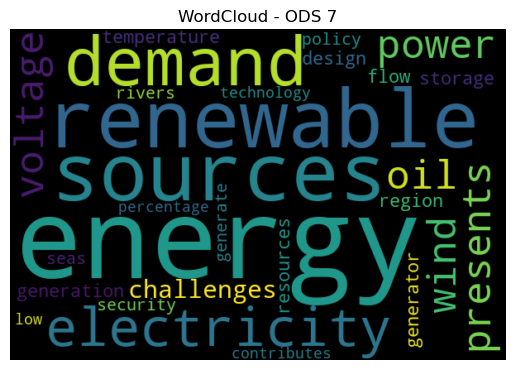

In [42]:
# --- WordClouds por ODS ---
for ods, keywords in ods_keywords.items():
    wordcloud = WordCloud(width=600, height=400, background_color='black').generate(' '.join(keywords))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud - {ods}")
    plt.show()